## Importing packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook

from matplotlib import pyplot as plt

## Loading data and preprocessing

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [3]:
def add_date_features(df):
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofweek'] = df['Date'].dt.dayofweek
    return df

In [4]:
train = add_date_features(train)
test = add_date_features(test)

## Testing models for the first store/product pair

In [5]:
store_id = 0
product_id = 0

In [6]:
train_pair = train[(train['store'] == store_id) & (train['product'] == product_id)]
test_pair = test[(test['store'] == store_id) & (test['product'] == product_id)]

In [7]:
train_pair = train_pair.sort_values("Date")

In [8]:
cutoff = int(len(train_pair) * 0.8)
train_data = train_pair.iloc[:cutoff]
val_data = train_pair.iloc[cutoff:]

In [9]:
X_train = train_data[['month', 'year', 'dayofweek']]
y_train = train_data['number_sold']
X_val = val_data[['month', 'year', 'dayofweek']]
y_val = val_data['number_sold']

X_test = test_pair[['month', 'year', 'dayofweek']]
y_test = test_pair['number_sold']

In [10]:
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['month', 'dayofweek']] = X_train_scaled[['month', 'dayofweek']].astype(str)
X_val_scaled[['month', 'dayofweek']] = X_val_scaled[['month', 'dayofweek']].astype(str)
X_test_scaled[['month', 'dayofweek']] = X_test_scaled[['month', 'dayofweek']].astype(str)

X_train_scaled = pd.get_dummies(X_train_scaled, dtype=int)
X_val_scaled = pd.get_dummies(X_val_scaled, dtype=int)
X_test_scaled = pd.get_dummies(X_test_scaled, dtype=int)

scaler = MinMaxScaler()

scaler.fit(X_train_scaled)

X_train_scaled.iloc[:,:] = scaler.transform(X_train_scaled)
X_val_scaled.iloc[:,:] = scaler.transform(X_val_scaled)
X_test_scaled.iloc[:,:] = scaler.transform(X_test_scaled)

## Ridge Regression Grid Search

In [11]:
ridge_pipeline = Pipeline([
        ('ridge', Ridge())
    ])
ridge_param_grid = {
        'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }

ridge_gs = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5)
ridge_gs.fit(X_train_scaled, y_train)
y_val_pred_ridge = ridge_gs.predict(X_val_scaled)
y_test_pred_ridge = ridge_gs.predict(X_test_scaled)
ridge_rmse = mean_squared_error(y_val, y_val_pred_ridge, squared=False)

In [12]:
ridge_rmse

11.61820066965783

In [13]:
ridge_gs.best_params_

{'ridge__alpha': 10.0}

In [14]:
mean_squared_error(y_test, y_test_pred_ridge, squared=False)

15.899625488713651

## Ridge Regression Hyperopt

In [15]:
# Define objective function for Ridge
def ridge_objective(params):
    model = Ridge(alpha=params['alpha'])
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return {'loss': rmse, 'status': STATUS_OK}

# Hyperparameter search space
ridge_space = {
    'alpha': hp.loguniform('alpha', np.log(1e-3), np.log(1e3))
}

ridge_trials = Trials()
best_ridge_params = fmin(
    fn=ridge_objective,
    space=ridge_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=ridge_trials,
    rstate=np.random.default_rng(42)
)

# Fit Ridge with best params
ridge_model = Ridge(alpha=best_ridge_params['alpha'])
ridge_model.fit(X_train_scaled, y_train)
y_val_pred_ridge = ridge_model.predict(X_val_scaled)

100%|███████████████████████████████████████████████| 30/30 [00:00<00:00, 223.83trial/s, best loss: 11.558420038902158]


In [16]:
best_ridge_params

{'alpha': 2.3920259770306846}

In [17]:
mean_squared_error(y_val, y_val_pred_ridge, squared=False)

11.558420038902158

In [18]:
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

In [19]:
mean_squared_error(y_test, y_test_pred_ridge, squared=False)

15.832395554178097

<BarContainer object of 20 artists>

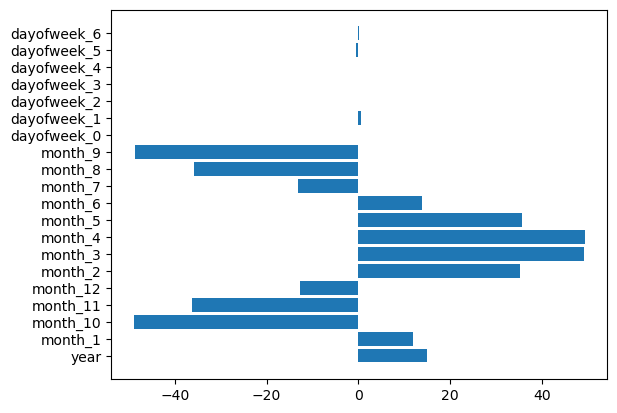

In [20]:
plt.barh(X_train_scaled.columns, ridge_model.coef_)

## Random Forest Grid Search

In [21]:
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1
)

rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
y_val_pred_rf = rf_best.predict(X_val_scaled)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [22]:
mean_squared_error(y_val, y_val_pred_rf, squared=False)

13.367993655164058

In [23]:
y_test_pred_rf = rf_best.predict(X_test_scaled)

In [24]:
mean_squared_error(y_test, y_test_pred_rf, squared=False)

23.69224074135475

## Random Forest Hyperopt

In [25]:
def objective(params):
        rf = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        pred = rf.predict(X_val_scaled)
        loss = mean_squared_error(y_val, pred, squared=False)
        return {'loss': loss, 'status': STATUS_OK}

space = {
        'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
    }

trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

rf_best = RandomForestRegressor(
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        min_samples_split=int(best_params['min_samples_split']),
        min_samples_leaf=int(best_params['min_samples_leaf']),
        random_state=42,
        n_jobs=-1
    )
rf_best.fit(X_train_scaled, y_train)
y_val_pred_rf = rf_best.predict(X_val_scaled)
y_test_pred_rf = rf_best.predict(X_test_scaled)
rf_rmse = mean_squared_error(y_val, y_val_pred_rf, squared=False)

100%|████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.43trial/s, best loss: 13.072197476560477]


In [26]:
rf_rmse

13.072197476560472

In [27]:
mean_squared_error(y_test, y_test_pred_rf, squared=False)

23.36245755463982

<BarContainer object of 20 artists>

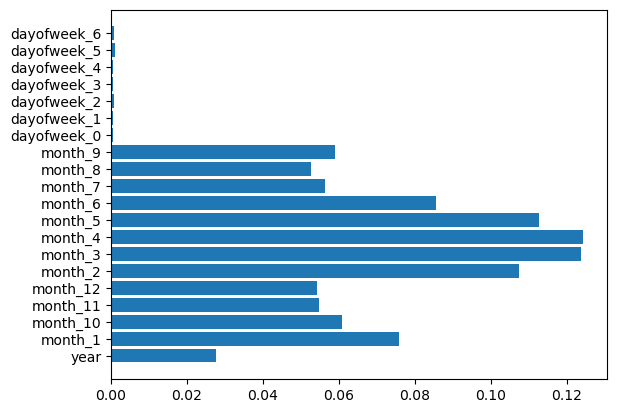

In [28]:
plt.barh(rf_best.feature_names_in_, rf_best.feature_importances_)

In [29]:
def objective(params):
        rf = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        pred = rf.predict(X_val)
        loss = mean_squared_error(y_val, pred, squared=False)
        return {'loss': loss, 'status': STATUS_OK}

space = {
        'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
    }

trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

rf_best = RandomForestRegressor(
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        min_samples_split=int(best_params['min_samples_split']),
        min_samples_leaf=int(best_params['min_samples_leaf']),
        random_state=42,
        n_jobs=-1
    )
rf_best.fit(X_train, y_train)
y_val_pred_rf = rf_best.predict(X_val)
y_test_pred_rf = rf_best.predict(X_test)
rf_rmse = mean_squared_error(y_val, y_val_pred_rf, squared=False)

100%|████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.62trial/s, best loss: 12.914526314110201]


In [30]:
rf_rmse

12.914526314110217

In [31]:
mean_squared_error(y_test, y_test_pred_rf, squared=False)

23.060208521639712

<BarContainer object of 3 artists>

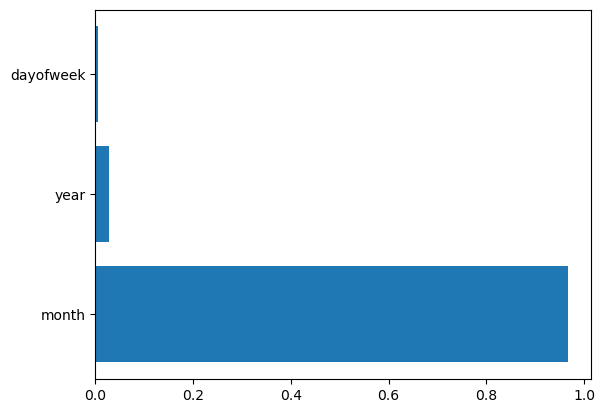

In [32]:
plt.barh(rf_best.feature_names_in_, rf_best.feature_importances_)

## Lightgbm Hyperopt

In [41]:
# Convert data
lgb_train = lgb.Dataset(X_train_scaled, label=y_train)
lgb_val = lgb.Dataset(X_val_scaled, label=y_val)

# Define the search space
space = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'min_child_samples': hp.quniform('min_child_samples', 10, 100, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
}

def objective(params):
    # Convert float params to int where necessary
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'seed': 42,
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'min_child_samples': int(params['min_child_samples']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'feature_pre_filter': 'false'
    }

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )

    preds = model.predict(X_val_scaled, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return {'loss': rmse, 'status': STATUS_OK}

# Run Hyperopt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Final training using best params
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])
best_params.update({
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'seed': 42
})

final_model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

# Predict on validation and test (optional)
y_val_pred_lgb = final_model.predict(X_val_scaled, num_iteration=final_model.best_iteration)
lgb_rmse = mean_squared_error(y_val, y_val_pred_lgb, squared=False)
print(f"LightGBM Hyperopt RMSE: {lgb_rmse:.4f}")


Training until validation scores don't improve for 50 rounds                                                           
Early stopping, best iteration is:                                                                                     
[52]	train's rmse: 11.4565	valid's rmse: 12.8011
Training until validation scores don't improve for 50 rounds                                                           
Early stopping, best iteration is:                                                                                     
[193]	train's rmse: 11.4644	valid's rmse: 12.8522
Training until validation scores don't improve for 50 rounds                                                           
Early stopping, best iteration is:                                                                                     
[125]	train's rmse: 11.4991	valid's rmse: 12.8561
Training until validation scores don't improve for 50 rounds                                                           
Early stopp

In [42]:
y_test_pred_lgb = final_model.predict(X_test_scaled, num_iteration=final_model.best_iteration)
lgb_rmse = mean_squared_error(y_test, y_test_pred_lgb, squared=False)

In [43]:
lgb_rmse

20.921946067743253

<BarContainer object of 20 artists>

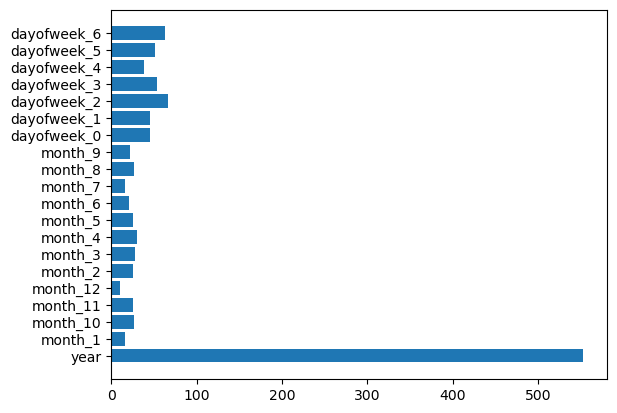

In [51]:
plt.barh(final_model.feature_name(), final_model.feature_importance())

## Looping through all store/product pairs

In [29]:
pairs = train[['store', 'product']].drop_duplicates()
results = []
prediction_test = []

for _, row in tqdm_notebook(pairs.iterrows()):
    store_id, product_id = row['store'], row['product']

    # Filter for that pair
    train_pair = train[(train['store'] == store_id) & (train['product'] == product_id)]
    test_pair = test[(test['store'] == store_id) & (test['product'] == product_id)]

    # Sort by Date
    train_pair = train_pair.sort_values("Date")

    # Time-based split: last 20% for validation
    cutoff = int(len(train_pair) * 0.8)
    train_data = train_pair.iloc[:cutoff]
    val_data = train_pair.iloc[cutoff:]

    X_train = train_data[['month', 'year', 'dayofweek']]
    y_train = train_data['number_sold']
    X_val = val_data[['month', 'year', 'dayofweek']]
    y_val = val_data['number_sold']

    X_test = test_pair[['month', 'year', 'dayofweek']]
    y_test = test_pair['number_sold']
    
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[['month', 'dayofweek']] = X_train_scaled[['month', 'dayofweek']].astype(str)
    X_val_scaled[['month', 'dayofweek']] = X_val_scaled[['month', 'dayofweek']].astype(str)
    X_test_scaled[['month', 'dayofweek']] = X_test_scaled[['month', 'dayofweek']].astype(str)

    X_train_scaled = pd.get_dummies(X_train_scaled, dtype=int)
    X_val_scaled = pd.get_dummies(X_val_scaled, dtype=int)
    X_test_scaled = pd.get_dummies(X_test_scaled, dtype=int)

    scaler = MinMaxScaler()

    scaler.fit(X_train_scaled)

    X_train_scaled.iloc[:,:] = scaler.transform(X_train_scaled)
    X_val_scaled.iloc[:,:] = scaler.transform(X_val_scaled)
    X_test_scaled.iloc[:,:] = scaler.transform(X_test_scaled)

    # -------- Ridge Regression + GridSearch --------
    
    
    ridge_pipeline = Pipeline([('ridge', Ridge())])
    ridge_param_grid = {
        'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }

    ridge_gs = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=3)
    ridge_gs.fit(X_train_scaled, y_train)
    y_val_pred_gd_ridge = ridge_gs.predict(X_val_scaled)
    y_test_pred_gd_ridge = ridge_gs.predict(X_test_scaled)
    ridge_rmse_gd_val = mean_squared_error(y_val, y_val_pred_gd_ridge, squared=False)
    ridge_rmse_gd_test = mean_squared_error(y_test, y_test_pred_gd_ridge, squared=False)
    test_pair['ridge_gd'] = y_test_pred_gd_ridge
    
    # -------- Ridge Regression + Hyperopt --------
    
    
    def ridge_objective(params):
        model = Ridge(alpha=params['alpha'])
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_val_scaled)
        rmse = mean_squared_error(y_val, preds, squared=False)
        return {'loss': rmse, 'status': STATUS_OK}

    ridge_space = {
        'alpha': hp.loguniform('alpha', np.log(1e-3), np.log(1e3))
    }

    ridge_trials = Trials()
    best_ridge_params = fmin(
        fn=ridge_objective,
        space=ridge_space,
        algo=tpe.suggest,
        max_evals=30,
        trials=ridge_trials,
        rstate=np.random.default_rng(42)
    )

    ridge_model = Ridge(alpha=best_ridge_params['alpha'])
    ridge_model.fit(X_train_scaled, y_train)
    y_val_pred_ho_ridge = ridge_model.predict(X_val_scaled)
    y_test_pred_ho_ridge = ridge_model.predict(X_test_scaled)
    ridge_rmse_ho_val = mean_squared_error(y_val, y_val_pred_ho_ridge, squared=False)
    ridge_rmse_ho_test = mean_squared_error(y_test, y_test_pred_ho_ridge, squared=False)
    test_pair['ridge_ho'] = y_test_pred_ho_ridge
    
    # -------- Random Forest + GridSearch --------
    
    
    rf_param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid=rf_param_grid,
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1
    )

    rf_grid.fit(X_train_scaled, y_train)
    rf_best = rf_grid.best_estimator_
    y_val_pred_gd_rf = rf_best.predict(X_val_scaled)
    y_test_pred_gd_rf = rf_best.predict(X_test_scaled)
    
    rf_rmse_gd_val = mean_squared_error(y_val, y_val_pred_gd_rf, squared=False)
    rf_rmse_gd_test = mean_squared_error(y_test, y_test_pred_gd_rf, squared=False)
    test_pair['rf_gd'] = y_test_pred_gd_rf

    
    # -------- Random Forest + Hyperopt --------
    
    
    def objective(params):
        rf = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_scaled, y_train)
        pred = rf.predict(X_val_scaled)
        loss = mean_squared_error(y_val, pred, squared=False)
        return {'loss': loss, 'status': STATUS_OK}

    space = {
        'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
    }

    trials = Trials()
    best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

    rf_best = RandomForestRegressor(
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        min_samples_split=int(best_params['min_samples_split']),
        min_samples_leaf=int(best_params['min_samples_leaf']),
        random_state=42,
        n_jobs=-1
    )
    rf_best.fit(X_train_scaled, y_train)
    y_val_pred_ho_rf = rf_best.predict(X_val_scaled)
    y_test_pred_ho_rf = rf_best.predict(X_test_scaled)
    rf_rmse_ho_val = mean_squared_error(y_val, y_val_pred_ho_rf, squared=False)
    rf_rmse_ho_test = mean_squared_error(y_test, y_test_pred_ho_rf, squared=False)
    test_pair['rf_ho'] = y_test_pred_ho_rf
    
    # -------- Lightgbm + Hyperopt --------
    
    
    lgb_train = lgb.Dataset(X_train_scaled, label=y_train)
    lgb_val = lgb.Dataset(X_val_scaled, label=y_val)

    space = {
        'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
        'min_child_samples': hp.quniform('min_child_samples', 10, 100, 1),
        'subsample': hp.uniform('subsample', 0.6, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    }

    def objective(params):
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'verbose': -1,
            'seed': 42,
            'num_leaves': int(params['num_leaves']),
            'max_depth': int(params['max_depth']),
            'learning_rate': params['learning_rate'],
            'min_child_samples': int(params['min_child_samples']),
            'subsample': params['subsample'],
            'colsample_bytree': params['colsample_bytree'],
            'feature_pre_filter': 'false'
        }

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_val],
            valid_names=['train', 'valid'],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        preds = model.predict(X_val_scaled, num_iteration=model.best_iteration)
        rmse = mean_squared_error(y_val, preds, squared=False)
        return {'loss': rmse, 'status': STATUS_OK}

    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=30,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    best_params['num_leaves'] = int(best_params['num_leaves'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_child_samples'] = int(best_params['min_child_samples'])
    best_params.update({
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1,
        'seed': 42
    })

    final_model = lgb.train(
        best_params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
    )

    y_val_pred_lgb = final_model.predict(X_val_scaled, num_iteration=final_model.best_iteration)
    y_test_pred_lgb = final_model.predict(X_test_scaled, num_iteration=final_model.best_iteration)
    lgb_rmse_val = mean_squared_error(y_val, y_val_pred_lgb, squared=False)
    lgb_rmse_test = mean_squared_error(y_test, y_test_pred_lgb, squared=False)
    test_pair['lgb'] = y_test_pred_lgb
    

    # Save predictions and metrics
    results.append({
        'store': store_id,
        'product': product_id,
        'ridge_rmse_gd_val': ridge_rmse_gd_val,
        'ridge_rmse_gd_test': ridge_rmse_gd_test,
        'ridge_rmse_ho_val': ridge_rmse_ho_val,
        'ridge_rmse_ho_test': ridge_rmse_ho_test,
        'rf_rmse_gd_val': rf_rmse_gd_val,
        'rf_rmse_gd_test': rf_rmse_gd_test,
        'rf_rmse_ho_val': rf_rmse_ho_val,
        'rf_rmse_ho_test': rf_rmse_ho_test,
        'lgb_rmse_val': lgb_rmse_val,
        'lgb_rmse_test': lgb_rmse_test
    })
    
    prediction_test.append(test_pair)

# Convert results to DataFrame for inspection
results_df = pd.DataFrame(results)
prediction_df = pd.concat(prediction_test)

0it [00:00, ?it/s]


100%|███████████████████████████████████████████████| 30/30 [00:00<00:00, 133.82trial/s, best loss: 11.558420038902158]
Fitting 3 folds for each of 36 candidates, totalling 108 fits

100%|█████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.45trial/s, best loss: 12.95341815453396]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[52]	train's rmse: 11.4565	valid's rmse: 12.8011

  0%|                                                                       

Training until validation scores don't improve for 50 rounds                                                        

 57%|███████████████████████████▏                    | 17/30 [00:07<00:07,  1.69trial/s, best loss: 12.223006878986972]
                                                                                                                    Early stopping, best iteration is:
[643]	train's rmse: 11.2265	valid's rmse: 12.2437

 60%|████████████████████████████▊                   | 18/30 [00:08<00:08,  1.48trial/s, best loss: 12.223006878986972]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 60%|████████████████████████████▊                   | 18/30 [00:08<00:08,  1.48trial/s, best loss: 12.223006878986972]
                                                                                                                    Early stopping, best itera

 13%|██████▌                                          | 4/30 [00:01<00:11,  2.33trial/s, best loss: 32.617550259636495]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 13%|██████▌                                          | 4/30 [00:01<00:11,  2.33trial/s, best loss: 32.617550259636495]
                                                                                                                    Early stopping, best iteration is:
[925]	train's rmse: 10.5276	valid's rmse: 31.361

 17%|████████▏                                        | 5/30 [00:02<00:18,  1.38trial/s, best loss: 31.360998134609652]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 17%|████████▏                                        | 5/30 [00:02<00:18,  1.38tri

 83%|████████████████████████████████████████        | 25/30 [00:15<00:01,  2.88trial/s, best loss: 30.517957821921918]
                                                                                                                    Early stopping, best iteration is:
[188]	train's rmse: 10.0144	valid's rmse: 30.5696

 87%|█████████████████████████████████████████▌      | 26/30 [00:16<00:01,  2.77trial/s, best loss: 30.517957821921918]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 87%|█████████████████████████████████████████▌      | 26/30 [00:16<00:01,  2.77trial/s, best loss: 30.517957821921918]
                                                                                                                    Early stopping, best iteration is:
[212]	train's rmse: 10.5296	valid's rmse: 30.1375

 90%|███████████████████████████████████████████▏    | 27/

Did not meet early stopping. Best iteration is:                                                                     
[976]	train's rmse: 11.7106	valid's rmse: 18.4861

 40%|████████████████████                              | 12/30 [00:07<00:14,  1.21trial/s, best loss: 17.7069307987628]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 40%|████████████████████                              | 12/30 [00:07<00:14,  1.21trial/s, best loss: 17.7069307987628]
                                                                                                                    Early stopping, best iteration is:
[562]	train's rmse: 11.8766	valid's rmse: 17.4912

 43%|████████████████████▊                           | 13/30 [00:08<00:11,  1.47trial/s, best loss: 17.491203661690644]
                                                                                            

100%|████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.56trial/s, best loss: 18.948722553507157]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[85]	train's rmse: 11.7259	valid's rmse: 18.9187

  3%|█▋                                               | 1/30 [00:00<00:14,  2.03trial/s, best loss: 18.918683072738606]
                                                                                                                    Training until validatio

Training until validation scores don't improve for 50 rounds                                                        

 63%|███████████████████████████████                  | 19/30 [01:03<00:51,  4.65s/trial, best loss: 17.71742217973987]
                                                                                                                    Early stopping, best iteration is:
[696]	train's rmse: 11.5835	valid's rmse: 18.976

 67%|████████████████████████████████▋                | 20/30 [01:05<00:37,  3.77s/trial, best loss: 17.71742217973987]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 67%|████████████████████████████████▋                | 20/30 [01:05<00:37,  3.77s/trial, best loss: 17.71742217973987]
                                                                                                                    Early stopping, best iterat

 17%|████████▏                                        | 5/30 [00:05<00:26,  1.06s/trial, best loss: 13.111936571529293]
                                                                                                                    Early stopping, best iteration is:
[122]	train's rmse: 11.5002	valid's rmse: 13.0408

 20%|█████████▊                                       | 6/30 [00:05<00:18,  1.31trial/s, best loss: 13.040802707077754]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 20%|█████████▊                                       | 6/30 [00:05<00:18,  1.31trial/s, best loss: 13.040802707077754]
                                                                                                                    Early stopping, best iteration is:
[213]	train's rmse: 11.1942	valid's rmse: 13.4294

 23%|███████████▍                                     | 7/

 90%|████████████████████████████████████████████     | 27/30 [00:20<00:01,  1.73trial/s, best loss: 12.92359588103832]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 90%|████████████████████████████████████████████     | 27/30 [00:20<00:01,  1.73trial/s, best loss: 12.92359588103832]
                                                                                                                    Early stopping, best iteration is:
[258]	train's rmse: 11.1501	valid's rmse: 13.579

 93%|█████████████████████████████████████████████▋   | 28/30 [00:20<00:01,  1.85trial/s, best loss: 12.92359588103832]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 93%|█████████████████████████████████████████████▋   | 28/30 [00:20<00:01,  1.85tr

 43%|████████████████████▊                           | 13/30 [00:03<00:05,  2.99trial/s, best loss: 16.167408918811116]
                                                                                                                    Early stopping, best iteration is:
[266]	train's rmse: 9.09712	valid's rmse: 15.968

 47%|██████████████████████▍                         | 14/30 [00:04<00:06,  2.45trial/s, best loss: 15.967993774434413]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 47%|██████████████████████▍                         | 14/30 [00:04<00:06,  2.45trial/s, best loss: 15.967993774434413]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 9.22678	valid's rmse: 16.6725

 50%|████████████████████████                

100%|████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70trial/s, best loss: 12.337176916585706]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[101]	train's rmse: 10.359	valid's rmse: 11.9685

  3%|█▋                                               | 1/30 [00:00<00:13,  2.14trial/s, best loss: 11.968478746908206]
                                                                                                                    Training until validatio

 70%|█████████████████████████████████▌              | 21/30 [00:34<00:14,  1.66s/trial, best loss: 11.840815999013756]
                                                                                                                    Early stopping, best iteration is:
[183]	train's rmse: 10.4307	valid's rmse: 12.0428

 73%|███████████████████████████████████▏            | 22/30 [00:34<00:10,  1.33s/trial, best loss: 11.840815999013756]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 73%|███████████████████████████████████▏            | 22/30 [00:34<00:10,  1.33s/trial, best loss: 11.840815999013756]
                                                                                                                    Early stopping, best iteration is:
[335]	train's rmse: 10.3865	valid's rmse: 11.9817

 77%|████████████████████████████████████▊           | 23/

 23%|███████████▍                                     | 7/30 [00:22<01:56,  5.07s/trial, best loss: 23.979874036343592]
                                                                                                                    Early stopping, best iteration is:
[674]	train's rmse: 13.421	valid's rmse: 29.0204

 27%|█████████████                                    | 8/30 [00:24<01:30,  4.13s/trial, best loss: 23.979874036343592]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|█████████████                                    | 8/30 [00:24<01:30,  4.13s/trial, best loss: 23.979874036343592]
                                                                                                                    Early stopping, best iteration is:
[221]	train's rmse: 10.3425	valid's rmse: 23.996

 30%|██████████████▋                                  | 9/30

 97%|███████████████████████████████████████████████▎ | 29/30 [01:28<00:01,  1.37s/trial, best loss: 22.63642618892337]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 97%|███████████████████████████████████████████████▎ | 29/30 [01:28<00:01,  1.37s/trial, best loss: 22.63642618892337]
                                                                                                                    Early stopping, best iteration is:
[630]	train's rmse: 10.5791	valid's rmse: 27.1168

100%|█████████████████████████████████████████████████| 30/30 [01:36<00:00,  3.21s/trial, best loss: 22.63642618892337]
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 11.0807	valid's rmse: 25.3435
[200]	train's rmse: 10.9957	valid's rmse: 23.8197
[300]	train's rmse: 10.9546	valid's rmse: 23.4484
[400]	train's rmse: 10.9385	valid's rmse: 23.2049

 50%|████████████████████████                        | 15/30 [00:43<01:24,  5.61s/trial, best loss: 31.078715953233036]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 50%|████████████████████████                        | 15/30 [00:43<01:24,  5.61s/trial, best loss: 31.078715953233036]
                                                                                                                    Early stopping, best iteration is:
[93]	train's rmse: 9.34591	valid's rmse: 34.4782

 53%|█████████████████████████▌                      | 16/30 [00:44<00:58,  4.16s/trial, best loss: 31.078715953233036]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 53%|█████████████████████████▌                      | 16/30 [00:44<00:58,  4.16s/t

  3%|█▋                                               | 1/30 [00:00<00:14,  1.98trial/s, best loss: 16.650018351960515]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  3%|█▋                                               | 1/30 [00:00<00:14,  1.98trial/s, best loss: 16.650018351960515]
                                                                                                                    Early stopping, best iteration is:
[304]	train's rmse: 10.7209	valid's rmse: 16.5074

  7%|███▎                                              | 2/30 [00:01<00:17,  1.56trial/s, best loss: 16.50741332577751]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  7%|███▎                                              | 2/30 [00:01<00:17,  1.56t

 73%|███████████████████████████████████▏            | 22/30 [01:22<00:37,  4.71s/trial, best loss: 15.450341487125794]
                                                                                                                    Early stopping, best iteration is:
[141]	train's rmse: 9.97147	valid's rmse: 16.7793

 77%|████████████████████████████████████▊           | 23/30 [01:24<00:27,  3.95s/trial, best loss: 15.450341487125794]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 77%|████████████████████████████████████▊           | 23/30 [01:24<00:27,  3.95s/trial, best loss: 15.450341487125794]
                                                                                                                    Early stopping, best iteration is:
[144]	train's rmse: 9.9799	valid's rmse: 15.6447

 80%|██████████████████████████████████████▍         | 24/3

 27%|██████████████▏                                      | 8/30 [00:05<00:18,  1.21trial/s, best loss: 13.54539246513]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|██████████████▏                                      | 8/30 [00:05<00:18,  1.21trial/s, best loss: 13.54539246513]
                                                                                                                    Early stopping, best iteration is:
[7]	train's rmse: 11.8476	valid's rmse: 13.6153

 30%|███████████████▉                                     | 9/30 [00:05<00:15,  1.32trial/s, best loss: 13.54539246513]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 30%|███████████████▉                                     | 9/30 [00:05<00:15,  1.32

Early stopping, best iteration is:                                                                                  
[267]	train's rmse: 12.3806	valid's rmse: 13.5727

100%|████████████████████████████████████████████████████| 30/30 [00:18<00:00,  1.59trial/s, best loss: 13.54539246513]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's rmse: 12.28	valid's rmse: 13.5454

100%|████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.67trial/s, best loss: 24.97890598622331]
Fitting 3 folds for each of 36 candidates, totalling 108 fits

100%|█████████████████████████████████████████████████| 25/25 [00:12<00:00,  2.08trial/s, best loss: 20.67872108588864]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation sc

 53%|██████████████████████████▏                      | 16/30 [00:13<00:19,  1.37s/trial, best loss: 19.33320503154203]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 53%|██████████████████████████▏                      | 16/30 [00:13<00:19,  1.37s/trial, best loss: 19.33320503154203]
                                                                                                                    Early stopping, best iteration is:
[176]	train's rmse: 15.8054	valid's rmse: 20.3584

 57%|███████████████████████████▊                     | 17/30 [00:14<00:15,  1.19s/trial, best loss: 19.33320503154203]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 57%|███████████████████████████▊                     | 17/30 [00:14<00:15,  1.19s

  7%|███▎                                             | 2/30 [00:00<00:05,  4.93trial/s, best loss: 17.946755228792227]
                                                                                                                    Early stopping, best iteration is:
[32]	train's rmse: 16.3553	valid's rmse: 17.7376

 10%|████▉                                            | 3/30 [00:00<00:05,  4.54trial/s, best loss: 17.737622982931068]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 10%|████▉                                            | 3/30 [00:00<00:05,  4.54trial/s, best loss: 17.737622982931068]
                                                                                                                    Early stopping, best iteration is:
[267]	train's rmse: 16.1345	valid's rmse: 17.7308

 13%|██████▌                                          | 4/3

 80%|███████████████████████████████████████▏         | 24/30 [00:16<00:02,  2.21trial/s, best loss: 17.53466238723102]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 80%|███████████████████████████████████████▏         | 24/30 [00:16<00:02,  2.21trial/s, best loss: 17.53466238723102]
                                                                                                                    Early stopping, best iteration is:
[6]	train's rmse: 16.2476	valid's rmse: 17.6465

 83%|████████████████████████████████████████▊        | 25/30 [00:16<00:02,  2.44trial/s, best loss: 17.53466238723102]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 83%|████████████████████████████████████████▊        | 25/30 [00:16<00:02,  2.44tri

 33%|████████████████                                | 10/30 [00:10<00:21,  1.06s/trial, best loss: 12.800600445557889]
                                                                                                                    Early stopping, best iteration is:
[21]	train's rmse: 12.319	valid's rmse: 12.9487

 37%|█████████████████▌                              | 11/30 [00:11<00:15,  1.19trial/s, best loss: 12.800600445557889]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 37%|█████████████████▌                              | 11/30 [00:11<00:15,  1.19trial/s, best loss: 12.800600445557889]
                                                                                                                    Early stopping, best iteration is:
[282]	train's rmse: 12.3218	valid's rmse: 13.1322

 40%|███████████████████▏                            | 12/30

100%|████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.47trial/s, best loss: 13.535045738959308]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[30]	train's rmse: 11.468	valid's rmse: 12.6406

  3%|█▋                                                | 1/30 [00:00<00:10,  2.89trial/s, best loss: 12.64056830781317]
                                                                                                                    Training until validation

 60%|████████████████████████████▊                   | 18/30 [00:17<00:15,  1.29s/trial, best loss: 12.623377789190272]
                                                                                                                    Early stopping, best iteration is:
[103]	train's rmse: 11.3023	valid's rmse: 12.7775

 63%|██████████████████████████████▍                 | 19/30 [00:18<00:13,  1.27s/trial, best loss: 12.623377789190272]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 63%|██████████████████████████████▍                 | 19/30 [00:18<00:13,  1.27s/trial, best loss: 12.623377789190272]
                                                                                                                    Early stopping, best iteration is:
[182]	train's rmse: 11.1965	valid's rmse: 12.8363

 67%|████████████████████████████████                | 20/

Early stopping, best iteration is:                                                                                  
[78]	train's rmse: 20.6576	valid's rmse: 19.2897

 17%|████████▏                                        | 5/30 [00:02<00:14,  1.73trial/s, best loss: 18.995472503039093]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 17%|████████▏                                        | 5/30 [00:02<00:14,  1.73trial/s, best loss: 18.995472503039093]
                                                                                                                    Early stopping, best iteration is:
[7]	train's rmse: 21.8627	valid's rmse: 19.7679

 20%|█████████▊                                       | 6/30 [00:02<00:12,  1.98trial/s, best loss: 18.995472503039093]
                                                                                               

Training until validation scores don't improve for 50 rounds                                                        

 87%|█████████████████████████████████████████▌      | 26/30 [00:20<00:03,  1.21trial/s, best loss: 18.478916948934653]
                                                                                                                    Early stopping, best iteration is:
[124]	train's rmse: 21.0347	valid's rmse: 19.1861

 90%|███████████████████████████████████████████▏    | 27/30 [00:21<00:02,  1.13trial/s, best loss: 18.478916948934653]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 90%|███████████████████████████████████████████▏    | 27/30 [00:21<00:02,  1.13trial/s, best loss: 18.478916948934653]
                                                                                                                    Early stopping, best itera

Training until validation scores don't improve for 50 rounds                                                        

 40%|███████████████████▏                            | 12/30 [00:10<00:23,  1.32s/trial, best loss: 16.989901538513507]
                                                                                                                    Early stopping, best iteration is:
[17]	train's rmse: 15.3674	valid's rmse: 17.568

 43%|████████████████████▊                           | 13/30 [00:11<00:17,  1.02s/trial, best loss: 16.989901538513507]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 43%|████████████████████▊                           | 13/30 [00:11<00:17,  1.02s/trial, best loss: 16.989901538513507]
                                                                                                                    Early stopping, best iterati

100%|████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.28trial/s, best loss: 12.132157522836955]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[482]	train's rmse: 9.6282	valid's rmse: 12.0119

  3%|█▋                                               | 1/30 [00:02<00:59,  2.07s/trial, best loss: 12.011863827885835]
                                                                                                                    Training until validatio

 67%|████████████████████████████████                | 20/30 [00:46<00:27,  2.78s/trial, best loss: 12.011863827885835]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 67%|████████████████████████████████                | 20/30 [00:46<00:27,  2.78s/trial, best loss: 12.011863827885835]
                                                                                                                    Did not meet early stopping. Best iteration is:
[985]	train's rmse: 9.80686	valid's rmse: 12.3227

 70%|█████████████████████████████████▌              | 21/30 [00:50<00:27,  3.05s/trial, best loss: 12.011863827885835]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 70%|█████████████████████████████████▌              | 21/30 [00:50<0

 20%|█████████▊                                       | 6/30 [00:10<00:32,  1.37s/trial, best loss: 15.255040166362637]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 20%|█████████▊                                       | 6/30 [00:10<00:32,  1.37s/trial, best loss: 15.255040166362637]
                                                                                                                    Early stopping, best iteration is:
[111]	train's rmse: 11.245	valid's rmse: 15.1599

 23%|███████████▍                                     | 7/30 [00:12<00:32,  1.43s/trial, best loss: 15.159896634911556]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 23%|███████████▍                                     | 7/30 [00:12<00:32,  1.43s/t

 90%|███████████████████████████████████████████▏    | 27/30 [00:50<00:06,  2.11s/trial, best loss: 15.159896634911556]
                                                                                                                    Early stopping, best iteration is:
[33]	train's rmse: 12.1356	valid's rmse: 19.3384

 93%|████████████████████████████████████████████▊   | 28/30 [00:51<00:03,  1.79s/trial, best loss: 15.159896634911556]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 93%|████████████████████████████████████████████▊   | 28/30 [00:51<00:03,  1.79s/trial, best loss: 15.159896634911556]
                                                                                                                    Early stopping, best iteration is:
[65]	train's rmse: 13.1059	valid's rmse: 18.6789

 97%|██████████████████████████████████████████████▍ | 29/30

Early stopping, best iteration is:                                                                                  
[27]	train's rmse: 12.3392	valid's rmse: 16.4362

 47%|██████████████████████▊                          | 14/30 [00:11<00:11,  1.33trial/s, best loss: 16.43624657508889]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 47%|██████████████████████▊                          | 14/30 [00:11<00:11,  1.33trial/s, best loss: 16.43624657508889]
                                                                                                                    Early stopping, best iteration is:
[255]	train's rmse: 12.6555	valid's rmse: 16.7634

 50%|████████████████████████▌                        | 15/30 [00:15<00:25,  1.73s/trial, best loss: 16.43624657508889]
                                                                                             

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[118]	train's rmse: 10.3213	valid's rmse: 16.5837

  3%|█▋                                               | 1/30 [00:00<00:17,  1.64trial/s, best loss: 16.583658037782698]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  3%|█▋                                               | 1/30 [00:00<00:17,  1.64tr

Early stopping, best iteration is:                                                                                  
[327]	train's rmse: 10.2641	valid's rmse: 12.258

 73%|███████████████████████████████████▏            | 22/30 [00:43<00:12,  1.59s/trial, best loss: 12.257979333568336]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 73%|███████████████████████████████████▏            | 22/30 [00:43<00:12,  1.59s/trial, best loss: 12.257979333568336]
                                                                                                                    Early stopping, best iteration is:
[374]	train's rmse: 10.2569	valid's rmse: 12.33

 77%|████████████████████████████████████▊           | 23/30 [00:44<00:09,  1.33s/trial, best loss: 12.257979333568336]
                                                                                               

 23%|███████████▍                                     | 7/30 [00:11<00:51,  2.23s/trial, best loss: 10.544268710490464]
                                                                                                                    Did not meet early stopping. Best iteration is:
[993]	train's rmse: 10.2897	valid's rmse: 11.7371

 27%|█████████████                                    | 8/30 [00:14<00:51,  2.34s/trial, best loss: 10.544268710490464]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|█████████████                                    | 8/30 [00:14<00:51,  2.34s/trial, best loss: 10.544268710490464]
                                                                                                                    Early stopping, best iteration is:
[71]	train's rmse: 9.67239	valid's rmse: 10.9282

 30%|██████████████▋                          

 97%|██████████████████████████████████████████████▍ | 29/30 [00:51<00:00,  1.17trial/s, best loss: 10.544268710490464]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 97%|██████████████████████████████████████████████▍ | 29/30 [00:52<00:00,  1.17trial/s, best loss: 10.544268710490464]
                                                                                                                    Early stopping, best iteration is:
[241]	train's rmse: 10.3569	valid's rmse: 11.6847

100%|████████████████████████████████████████████████| 30/30 [00:52<00:00,  1.75s/trial, best loss: 10.544268710490464]
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 10.6229	valid's rmse: 10.9223
[200]	train's rmse: 10.3271	valid's rmse: 10.5683
[300]	train's rmse: 10.2795	valid's rmse: 10.5498
Early stopping, best iteration is:
[315]	train's 

Training until validation scores don't improve for 50 rounds                                                        

 50%|████████████████████████                        | 15/30 [00:41<01:24,  5.61s/trial, best loss: 15.178477110677221]
                                                                                                                    Early stopping, best iteration is:
[144]	train's rmse: 9.48655	valid's rmse: 16.5873

 53%|█████████████████████████▌                      | 16/30 [00:42<00:59,  4.26s/trial, best loss: 15.178477110677221]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 53%|█████████████████████████▌                      | 16/30 [00:42<00:59,  4.26s/trial, best loss: 15.178477110677221]
                                                                                                                    Early stopping, best itera

Training until validation scores don't improve for 50 rounds                                                        

  3%|█▋                                               | 1/30 [00:01<00:37,  1.28s/trial, best loss: 11.493185194084177]
                                                                                                                    Early stopping, best iteration is:
[567]	train's rmse: 10.7316	valid's rmse: 11.4956

  7%|███▎                                             | 2/30 [00:02<00:34,  1.23s/trial, best loss: 11.493185194084177]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  7%|███▎                                             | 2/30 [00:02<00:34,  1.23s/trial, best loss: 11.493185194084177]
                                                                                                                    Early stopping, best itera

 77%|████████████████████████████████████▊           | 23/30 [01:05<00:14,  2.07s/trial, best loss: 11.253587164281495]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 77%|████████████████████████████████████▊           | 23/30 [01:05<00:14,  2.07s/trial, best loss: 11.253587164281495]
                                                                                                                    Early stopping, best iteration is:
[397]	train's rmse: 10.7528	valid's rmse: 11.2565

 80%|██████████████████████████████████████▍         | 24/30 [01:06<00:10,  1.72s/trial, best loss: 11.253587164281495]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 80%|██████████████████████████████████████▍         | 24/30 [01:06<00:10,  1.72s/

 30%|███████████████                                   | 9/30 [00:16<00:34,  1.67s/trial, best loss: 10.46432392184469]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 30%|███████████████                                   | 9/30 [00:16<00:34,  1.67s/trial, best loss: 10.46432392184469]
                                                                                                                    Early stopping, best iteration is:
[221]	train's rmse: 10.0171	valid's rmse: 10.6872

 33%|████████████████▎                                | 10/30 [00:17<00:31,  1.59s/trial, best loss: 10.46432392184469]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 33%|████████████████▎                                | 10/30 [00:17<00:31,  1.59s


100%|████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.17trial/s, best loss: 12.982878901726252]
Fitting 3 folds for each of 36 candidates, totalling 108 fits

100%|████████████████████████████████████████████████| 25/25 [00:17<00:00,  1.42trial/s, best loss: 17.439999399582476]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[93]	train's rmse: 10.1487	valid's rmse: 23.9145

  3%|█▋                                               | 1/30 [00:00<00:10,  

Early stopping, best iteration is:                                                                                  
[461]	train's rmse: 10.1578	valid's rmse: 24.139

 57%|███████████████████████████▏                    | 17/30 [00:45<00:49,  3.77s/trial, best loss: 14.282156227301412]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 57%|███████████████████████████▏                    | 17/30 [00:45<00:49,  3.77s/trial, best loss: 14.282156227301412]
                                                                                                                    Did not meet early stopping. Best iteration is:
[998]	train's rmse: 9.77261	valid's rmse: 14.7043

 60%|████████████████████████████▊                   | 18/30 [00:50<00:49,  4.15s/trial, best loss: 14.282156227301412]
                                                                                

  7%|███▎                                             | 2/30 [00:02<00:35,  1.28s/trial, best loss: 18.130928254883894]
                                                                                                                    Did not meet early stopping. Best iteration is:
[998]	train's rmse: 11.2914	valid's rmse: 13.8065

 10%|████▉                                            | 3/30 [00:04<00:43,  1.62s/trial, best loss: 13.806463386573608]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 10%|████▉                                            | 3/30 [00:04<00:43,  1.62s/trial, best loss: 13.806463386573608]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 11.4987	valid's rmse: 17.6198

 13%|██████▌                   

 80%|██████████████████████████████████████▍         | 24/30 [01:10<00:10,  1.75s/trial, best loss: 13.580626805127487]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 80%|██████████████████████████████████████▍         | 24/30 [01:10<00:10,  1.75s/trial, best loss: 13.580626805127487]
                                                                                                                    Early stopping, best iteration is:
[516]	train's rmse: 11.3412	valid's rmse: 13.4548

 83%|████████████████████████████████████████        | 25/30 [01:11<00:07,  1.52s/trial, best loss: 13.454846882920146]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 83%|████████████████████████████████████████        | 25/30 [01:11<00:07,  1.52s/

Training until validation scores don't improve for 50 rounds                                                        

 33%|████████████████▎                                | 10/30 [00:22<00:47,  2.39s/trial, best loss: 17.28817691831873]
                                                                                                                    Early stopping, best iteration is:
[212]	train's rmse: 9.20784	valid's rmse: 21.3844

 37%|█████████████████▉                               | 11/30 [00:23<00:37,  1.99s/trial, best loss: 17.28817691831873]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 37%|█████████████████▉                               | 11/30 [00:23<00:37,  1.99s/trial, best loss: 17.28817691831873]
                                                                                                                    Did not meet early stoppin

100%|████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.87trial/s, best loss: 12.920248042091776]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[201]	train's rmse: 9.98021	valid's rmse: 13.4254

  3%|█▋                                               | 1/30 [00:00<00:03,  7.60trial/s, best loss: 13.425367486105216]
                                                                                                                    Training until validati

 60%|████████████████████████████▊                   | 18/30 [00:09<00:07,  1.55trial/s, best loss: 11.254200975576262]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 60%|████████████████████████████▊                   | 18/30 [00:09<00:07,  1.55trial/s, best loss: 11.254200975576262]
                                                                                                                    Did not meet early stopping. Best iteration is:
[999]	train's rmse: 9.53592	valid's rmse: 11.4969

 63%|██████████████████████████████▍                 | 19/30 [00:10<00:07,  1.44trial/s, best loss: 11.254200975576262]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 63%|██████████████████████████████▍                 | 19/30 [00:10<0

Training until validation scores don't improve for 50 rounds                                                        

 13%|██████▊                                            | 4/30 [00:01<00:13,  1.91trial/s, best loss: 11.4463621378183]
                                                                                                                    Early stopping, best iteration is:
[699]	train's rmse: 10.535	valid's rmse: 11.5082

 17%|████████▌                                          | 5/30 [00:02<00:14,  1.71trial/s, best loss: 11.4463621378183]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 17%|████████▌                                          | 5/30 [00:02<00:14,  1.71trial/s, best loss: 11.4463621378183]
                                                                                                                    Early stopping, best iterat

 87%|██████████████████████████████████████████▍      | 26/30 [00:18<00:01,  2.74trial/s, best loss: 11.36610068607582]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 87%|██████████████████████████████████████████▍      | 26/30 [00:18<00:01,  2.74trial/s, best loss: 11.36610068607582]
                                                                                                                    Early stopping, best iteration is:
[395]	train's rmse: 10.6601	valid's rmse: 11.3702

 90%|████████████████████████████████████████████     | 27/30 [00:18<00:00,  3.11trial/s, best loss: 11.36610068607582]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 90%|████████████████████████████████████████████     | 27/30 [00:18<00:00,  3.11t

Training until validation scores don't improve for 50 rounds                                                        

 40%|███████████████████▏                            | 12/30 [00:05<00:08,  2.01trial/s, best loss: 11.193431928415576]
                                                                                                                    Early stopping, best iteration is:
[140]	train's rmse: 9.72849	valid's rmse: 11.2137

 43%|████████████████████▊                           | 13/30 [00:05<00:06,  2.58trial/s, best loss: 11.193431928415576]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 43%|████████████████████▊                           | 13/30 [00:05<00:06,  2.58trial/s, best loss: 11.193431928415576]
                                                                                                                    Early stopping, best itera

100%|████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.95trial/s, best loss: 10.873307752685736]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[219]	train's rmse: 9.72033	valid's rmse: 10.4212

  3%|█▋                                               | 1/30 [00:00<00:06,  4.70trial/s, best loss: 10.421248289623614]
                                                                                                                    Training until validati

 67%|████████████████████████████████                | 20/30 [00:13<00:07,  1.28trial/s, best loss: 10.148343064795315]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 67%|████████████████████████████████                | 20/30 [00:13<00:07,  1.28trial/s, best loss: 10.148343064795315]
                                                                                                                    Early stopping, best iteration is:
[278]	train's rmse: 9.57786	valid's rmse: 10.2835

 70%|█████████████████████████████████▌              | 21/30 [00:13<00:05,  1.51trial/s, best loss: 10.148343064795315]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 70%|█████████████████████████████████▌              | 21/30 [00:13<00:05,  1.51tr


100%|████████████████████████████████████████████████| 30/30 [00:00<00:00, 130.79trial/s, best loss: 9.866534806700743]
Fitting 3 folds for each of 36 candidates, totalling 108 fits

100%|████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.76trial/s, best loss: 10.050615587894216]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[77]	train's rmse: 9.92952	valid's rmse: 10.0822

  3%|█▋                                               | 1/30 [00:00<00:03,  

 57%|███████████████████████████▊                     | 17/30 [00:05<00:05,  2.38trial/s, best loss: 9.912903886046706]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 57%|███████████████████████████▊                     | 17/30 [00:05<00:05,  2.38trial/s, best loss: 9.912903886046706]
                                                                                                                    Early stopping, best iteration is:
[355]	train's rmse: 9.9314	valid's rmse: 9.93392

 60%|█████████████████████████████▍                   | 18/30 [00:06<00:05,  2.35trial/s, best loss: 9.912903886046706]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 60%|█████████████████████████████▍                   | 18/30 [00:06<00:05,  2.35tr

Early stopping, best iteration is:                                                                                  
[755]	train's rmse: 10.1835	valid's rmse: 10.4001

 13%|██████▌                                          | 4/30 [00:01<00:09,  2.73trial/s, best loss: 10.291764699014111]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 13%|██████▌                                          | 4/30 [00:01<00:09,  2.73trial/s, best loss: 10.291764699014111]
                                                                                                                    Early stopping, best iteration is:
[351]	train's rmse: 10.1434	valid's rmse: 10.3567

 17%|████████▏                                        | 5/30 [00:01<00:08,  2.82trial/s, best loss: 10.291764699014111]
                                                                                            

 50%|████████████████████████                        | 15/30 [00:06<00:11,  1.35trial/s, best loss: 10.291764699014111]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 50%|████████████████████████                        | 15/30 [00:06<00:11,  1.35trial/s, best loss: 10.291764699014111]
                                                                                                                    Early stopping, best iteration is:
[66]	train's rmse: 9.97386	valid's rmse: 10.4815

 53%|█████████████████████████▌                      | 16/30 [00:06<00:08,  1.67trial/s, best loss: 10.291764699014111]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 53%|█████████████████████████▌                      | 16/30 [00:06<00:08,  1.67tri

  3%|█▋                                               | 1/30 [00:00<00:04,  6.33trial/s, best loss: 11.162344114196479]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  3%|█▋                                               | 1/30 [00:00<00:04,  6.33trial/s, best loss: 11.162344114196479]
                                                                                                                    Early stopping, best iteration is:
[430]	train's rmse: 9.9779	valid's rmse: 11.1097

  7%|███▎                                             | 2/30 [00:00<00:06,  4.42trial/s, best loss: 11.109691401044676]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  7%|███▎                                             | 2/30 [00:00<00:06,  4.42tri

 40%|███████████████████▌                             | 12/30 [00:06<00:10,  1.66trial/s, best loss: 10.73200862143036]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 40%|███████████████████▌                             | 12/30 [00:06<00:10,  1.66trial/s, best loss: 10.73200862143036]
                                                                                                                    Early stopping, best iteration is:
[115]	train's rmse: 9.94407	valid's rmse: 10.6249

 43%|████████████████████▊                           | 13/30 [00:06<00:07,  2.21trial/s, best loss: 10.624860975916361]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 43%|████████████████████▊                           | 13/30 [00:06<00:07,  2.21tr

100%|█████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.66trial/s, best loss: 9.855233044912806]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[89]	train's rmse: 9.80878	valid's rmse: 9.81444

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validatio

 70%|██████████████████████████████████▎              | 21/30 [00:05<00:03,  2.83trial/s, best loss: 9.762923902895663]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 70%|██████████████████████████████████▎              | 21/30 [00:05<00:03,  2.83trial/s, best loss: 9.762923902895663]
                                                                                                                    Early stopping, best iteration is:
[589]	train's rmse: 9.903	valid's rmse: 9.75653

 73%|███████████████████████████████████▉             | 22/30 [00:05<00:02,  3.23trial/s, best loss: 9.756533494440285]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 73%|███████████████████████████████████▉             | 22/30 [00:05<00:02,  3.23tri

 23%|███████████▍                                     | 7/30 [00:01<00:06,  3.52trial/s, best loss: 10.392165754736258]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 10.1848	valid's rmse: 10.4678

 27%|█████████████                                    | 8/30 [00:02<00:07,  3.05trial/s, best loss: 10.392165754736258]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|█████████████                                    | 8/30 [00:02<00:07,  3.05trial/s, best loss: 10.392165754736258]
                                                                                                                    Early stopping, best iteration is:
[25]	train's rmse: 9.82759	valid's rmse: 10.6249

 27%|█████████████                           

 97%|███████████████████████████████████████████████▎ | 29/30 [00:08<00:00,  6.11trial/s, best loss: 10.35650339889362]
                                                                                                                    Early stopping, best iteration is:
[192]	train's rmse: 9.97919	valid's rmse: 10.5098

100%|█████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.65trial/s, best loss: 10.35650339889362]
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 11.171	valid's rmse: 11.5264
[200]	train's rmse: 10.3233	valid's rmse: 10.4734
[300]	train's rmse: 10.237	valid's rmse: 10.3706
Early stopping, best iteration is:
[342]	train's rmse: 10.2224	valid's rmse: 10.3565

100%|█████████████████████████████████████████████████| 30/30 [00:00<00:00, 168.43trial/s, best loss: 10.0213091702101]
Fitting 3 folds for each of 36 candidates, totalling 108 fits

100%|████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.66

 53%|██████████████████████████▏                      | 16/30 [00:06<00:08,  1.59trial/s, best loss: 10.18309170576205]
                                                                                                                    Early stopping, best iteration is:
[608]	train's rmse: 9.96695	valid's rmse: 10.2935

 57%|███████████████████████████▊                     | 17/30 [00:06<00:05,  2.25trial/s, best loss: 10.18309170576205]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 57%|███████████████████████████▊                     | 17/30 [00:06<00:05,  2.25trial/s, best loss: 10.18309170576205]
                                                                                                                    Did not meet early stopping. Best iteration is:
[999]	train's rmse: 9.81976	valid's rmse: 10.262

 60%|█████████████████████████████▍           

 10%|█████                                             | 3/30 [00:00<00:04,  5.92trial/s, best loss: 10.40705442566278]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 10%|█████                                             | 3/30 [00:00<00:04,  5.92trial/s, best loss: 10.40705442566278]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 9.76312	valid's rmse: 10.7059

 13%|██████▋                                           | 4/30 [00:00<00:07,  3.33trial/s, best loss: 10.40705442566278]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 13%|██████▋                                           | 4/30 [00:01

 80%|██████████████████████████████████████▍         | 24/30 [00:09<00:02,  2.78trial/s, best loss: 10.205830576621656]
                                                                                                                    Early stopping, best iteration is:
[357]	train's rmse: 9.80848	valid's rmse: 10.3815

 83%|████████████████████████████████████████        | 25/30 [00:09<00:01,  3.46trial/s, best loss: 10.205830576621656]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 83%|████████████████████████████████████████        | 25/30 [00:09<00:01,  3.46trial/s, best loss: 10.205830576621656]
                                                                                                                    Early stopping, best iteration is:
[691]	train's rmse: 9.64169	valid's rmse: 10.5002

 87%|█████████████████████████████████████████▌      | 26/

 33%|████████████████                                | 10/30 [00:02<00:04,  4.49trial/s, best loss: 10.479455082640639]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 37%|█████████████████▌                              | 11/30 [00:02<00:04,  4.49trial/s, best loss: 10.479455082640639]
                                                                                                                    Early stopping, best iteration is:
[708]	train's rmse: 9.39725	valid's rmse: 10.5306

 40%|███████████████████▏                            | 12/30 [00:03<00:05,  3.33trial/s, best loss: 10.479455082640639]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 40%|███████████████████▏                            | 12/30 [00:03<00:05,  3.33tr

100%|████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.47trial/s, best loss: 19.309821871490428]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[281]	train's rmse: 9.72	valid's rmse: 23.9723

  3%|█▋                                                | 1/30 [00:00<00:04,  6.71trial/s, best loss: 23.97226067048843]
                                                                                                                    Training until validation 

 67%|████████████████████████████████                | 20/30 [00:08<00:05,  1.88trial/s, best loss: 17.963138291949505]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 67%|████████████████████████████████                | 20/30 [00:08<00:05,  1.88trial/s, best loss: 17.963138291949505]
                                                                                                                    Early stopping, best iteration is:
[583]	train's rmse: 9.7913	valid's rmse: 17.9924

 70%|█████████████████████████████████▌              | 21/30 [00:08<00:03,  2.35trial/s, best loss: 17.963138291949505]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 70%|█████████████████████████████████▌              | 21/30 [00:08<00:03,  2.35tri

 20%|█████████▊                                       | 6/30 [00:01<00:07,  3.05trial/s, best loss: 27.009602928226364]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 20%|█████████▊                                       | 6/30 [00:01<00:07,  3.05trial/s, best loss: 27.009602928226364]
                                                                                                                    Early stopping, best iteration is:
[376]	train's rmse: 9.04784	valid's rmse: 29.7671

 23%|███████████▍                                     | 7/30 [00:02<00:11,  2.03trial/s, best loss: 27.009602928226364]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 23%|███████████▍                                     | 7/30 [00:02<00:11,  2.03tr

 57%|███████████████████████████▏                    | 17/30 [00:07<00:07,  1.76trial/s, best loss: 27.009602928226364]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 57%|███████████████████████████▏                    | 17/30 [00:07<00:07,  1.76trial/s, best loss: 27.009602928226364]
                                                                                                                    Did not meet early stopping. Best iteration is:
[999]	train's rmse: 9.85642	valid's rmse: 30.4362

 60%|████████████████████████████▊                   | 18/30 [00:08<00:07,  1.63trial/s, best loss: 27.009602928226364]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 60%|████████████████████████████▊                   | 18/30 [00:08<0

 10%|█████                                             | 3/30 [00:00<00:05,  4.80trial/s, best loss: 30.78592543894534]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 10%|█████                                             | 3/30 [00:00<00:05,  4.80trial/s, best loss: 30.78592543894534]
                                                                                                                    Did not meet early stopping. Best iteration is:
[999]	train's rmse: 12.2264	valid's rmse: 34.301

 13%|██████▋                                           | 4/30 [00:01<00:09,  2.81trial/s, best loss: 30.78592543894534]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 13%|██████▋                                           | 4/30 [00:01<0

 47%|██████████████████████▊                          | 14/30 [00:04<00:04,  3.62trial/s, best loss: 30.78592543894534]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 47%|██████████████████████▊                          | 14/30 [00:04<00:04,  3.62trial/s, best loss: 30.78592543894534]
                                                                                                                    Early stopping, best iteration is:
[722]	train's rmse: 10.7034	valid's rmse: 35.3176

 50%|████████████████████████▌                        | 15/30 [00:05<00:09,  1.62trial/s, best loss: 30.78592543894534]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 50%|████████████████████████▌                        | 15/30 [00:05<00:09,  1.62t

100%|█████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.30trial/s, best loss: 37.15139247205674]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[437]	train's rmse: 11.587	valid's rmse: 39.6163

  3%|█▋                                                | 1/30 [00:00<00:11,  2.61trial/s, best loss: 39.61626359284724]
                                                                                                                    Training until validatio

 70%|███████████████████████████████████               | 21/30 [00:19<00:07,  1.22trial/s, best loss: 30.0131950638264]
                                                                                                                    Early stopping, best iteration is:
[776]	train's rmse: 11.4718	valid's rmse: 29.8782

 73%|███████████████████████████████████▏            | 22/30 [00:19<00:05,  1.46trial/s, best loss: 29.878223030159933]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 73%|███████████████████████████████████▏            | 22/30 [00:19<00:05,  1.46trial/s, best loss: 29.878223030159933]
                                                                                                                    Early stopping, best iteration is:
[803]	train's rmse: 11.7605	valid's rmse: 39.5762

 77%|████████████████████████████████████▊           | 23/

Did not meet early stopping. Best iteration is:                                                                     
[999]	train's rmse: 10.401	valid's rmse: 11.3894

 27%|█████████████                                    | 8/30 [00:03<00:12,  1.83trial/s, best loss: 11.251482278992004]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|█████████████                                    | 8/30 [00:03<00:12,  1.83trial/s, best loss: 11.251482278992004]
                                                                                                                    Early stopping, best iteration is:
[28]	train's rmse: 10.0021	valid's rmse: 11.7409

 30%|██████████████▋                                  | 9/30 [00:03<00:09,  2.33trial/s, best loss: 11.251482278992004]
                                                                                              

Training until validation scores don't improve for 50 rounds                                                        

 97%|██████████████████████████████████████████████▍ | 29/30 [00:15<00:00,  2.82trial/s, best loss: 11.237948982758418]
                                                                                                                    Early stopping, best iteration is:
[353]	train's rmse: 10.1361	valid's rmse: 11.2838

100%|████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.86trial/s, best loss: 11.237948982758418]
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 10.8748	valid's rmse: 11.9376
[200]	train's rmse: 10.5275	valid's rmse: 11.4586
[300]	train's rmse: 10.3931	valid's rmse: 11.3232
[400]	train's rmse: 10.3053	valid's rmse: 11.2715
[500]	train's rmse: 10.2435	valid's rmse: 11.2379
Early stopping, best iteration is:
[500]	train's rmse: 10.2435	valid's rmse: 11.2379

100%|██████████████████████████████████████

Training until validation scores don't improve for 50 rounds                                                        

 50%|████████████████████████▌                        | 15/30 [00:13<00:25,  1.70s/trial, best loss: 31.10897540518853]
                                                                                                                    Early stopping, best iteration is:
[116]	train's rmse: 9.65168	valid's rmse: 34.0317

 53%|██████████████████████████▏                      | 16/30 [00:13<00:17,  1.27s/trial, best loss: 31.10897540518853]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 53%|██████████████████████████▏                      | 16/30 [00:13<00:17,  1.27s/trial, best loss: 31.10897540518853]
                                                                                                                    Did not meet early stoppin

  3%|█▋                                                 | 1/30 [00:00<00:06,  4.74trial/s, best loss: 36.1643469544814]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  3%|█▋                                                 | 1/30 [00:00<00:06,  4.74trial/s, best loss: 36.1643469544814]
                                                                                                                    Early stopping, best iteration is:
[912]	train's rmse: 11.4463	valid's rmse: 36.0816

  7%|███▎                                             | 2/30 [00:00<00:09,  2.99trial/s, best loss: 36.081577664338965]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  7%|███▎                                             | 2/30 [00:00<00:09,  2.99tr

 73%|███████████████████████████████████▏            | 22/30 [00:18<00:05,  1.49trial/s, best loss: 28.878243281050572]
                                                                                                                    Early stopping, best iteration is:
[196]	train's rmse: 11.0953	valid's rmse: 30.004

 77%|████████████████████████████████████▊           | 23/30 [00:18<00:03,  1.86trial/s, best loss: 28.878243281050572]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 77%|████████████████████████████████████▊           | 23/30 [00:18<00:03,  1.86trial/s, best loss: 28.878243281050572]
                                                                                                                    Early stopping, best iteration is:
[216]	train's rmse: 11.0826	valid's rmse: 28.8797

 80%|██████████████████████████████████████▍         | 24/3

Early stopping, best iteration is:                                                                                  
[224]	train's rmse: 10.328	valid's rmse: 30.3186

 30%|███████████████                                   | 9/30 [00:06<00:15,  1.35trial/s, best loss: 28.69598195416949]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 30%|███████████████                                   | 9/30 [00:06<00:15,  1.35trial/s, best loss: 28.69598195416949]
                                                                                                                    Early stopping, best iteration is:
[581]	train's rmse: 10.8262	valid's rmse: 31.388

 33%|████████████████▎                                | 10/30 [00:06<00:14,  1.36trial/s, best loss: 28.69598195416949]
                                                                                              

 63%|██████████████████████████████▍                 | 19/30 [00:17<00:13,  1.27s/trial, best loss: 27.580717729395584]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 11.8098	valid's rmse: 40.3651

 67%|████████████████████████████████                | 20/30 [00:18<00:10,  1.07s/trial, best loss: 27.580717729395584]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 67%|████████████████████████████████                | 20/30 [00:18<00:10,  1.07s/trial, best loss: 27.580717729395584]
                                                                                                                    Early stopping, best iteration is:
[630]	train's rmse: 11.2064	valid's rmse: 29.3205

 70%|█████████████████████████████████▌     

 17%|████████▏                                        | 5/30 [00:01<00:10,  2.37trial/s, best loss: 10.131244762689777]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 17%|████████▏                                        | 5/30 [00:01<00:10,  2.37trial/s, best loss: 10.131244762689777]
                                                                                                                    Early stopping, best iteration is:
[43]	train's rmse: 9.67179	valid's rmse: 10.2088

 20%|█████████▊                                       | 6/30 [00:01<00:07,  3.09trial/s, best loss: 10.131244762689777]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 20%|█████████▊                                       | 6/30 [00:01<00:07,  3.09tri

 87%|█████████████████████████████████████████▌      | 26/30 [00:10<00:01,  3.80trial/s, best loss: 10.116592699982295]
                                                                                                                    Early stopping, best iteration is:
[263]	train's rmse: 9.82754	valid's rmse: 10.3269

 90%|███████████████████████████████████████████▏    | 27/30 [00:11<00:00,  3.67trial/s, best loss: 10.116592699982295]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 90%|███████████████████████████████████████████▏    | 27/30 [00:11<00:00,  3.67trial/s, best loss: 10.116592699982295]
                                                                                                                    Early stopping, best iteration is:
[141]	train's rmse: 9.77964	valid's rmse: 10.1601

 93%|████████████████████████████████████████████▊   | 28/

Early stopping, best iteration is:                                                                                  
[788]	train's rmse: 10.4193	valid's rmse: 38.7001

 43%|█████████████████████▏                           | 13/30 [00:06<00:09,  1.86trial/s, best loss: 38.66235174167675]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 43%|█████████████████████▏                           | 13/30 [00:06<00:09,  1.86trial/s, best loss: 38.66235174167675]
                                                                                                                    Early stopping, best iteration is:
[696]	train's rmse: 9.77184	valid's rmse: 41.1761

 47%|██████████████████████▊                          | 14/30 [00:08<00:12,  1.26trial/s, best loss: 38.66235174167675]
                                                                                            

 77%|█████████████████████████████████████▌           | 23/30 [00:13<00:02,  2.85trial/s, best loss: 36.17590805545353]
                                                                                                                    Early stopping, best iteration is:
[739]	train's rmse: 10.5205	valid's rmse: 38.1827

 80%|███████████████████████████████████████▏         | 24/30 [00:13<00:01,  3.01trial/s, best loss: 36.17590805545353]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 80%|███████████████████████████████████████▏         | 24/30 [00:13<00:01,  3.01trial/s, best loss: 36.17590805545353]
                                                                                                                    Early stopping, best iteration is:
[212]	train's rmse: 11.0654	valid's rmse: 48.85

 80%|███████████████████████████████████████▏         | 24/3

Early stopping, best iteration is:                                                                                  
[381]	train's rmse: 10.2871	valid's rmse: 15.0384

 33%|████████████████                                | 10/30 [00:03<00:07,  2.55trial/s, best loss: 13.252202034451571]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 33%|████████████████                                | 10/30 [00:03<00:07,  2.55trial/s, best loss: 13.252202034451571]
                                                                                                                    Early stopping, best iteration is:
[151]	train's rmse: 10.1448	valid's rmse: 14.0103

 37%|█████████████████▌                              | 11/30 [00:04<00:06,  3.03trial/s, best loss: 13.252202034451571]
                                                                                            

 67%|████████████████████████████████                | 20/30 [00:09<00:05,  1.80trial/s, best loss: 13.252202034451571]
                                                                                                                    Early stopping, best iteration is:
[511]	train's rmse: 10.619	valid's rmse: 13.5885

 70%|█████████████████████████████████▌              | 21/30 [00:09<00:04,  2.22trial/s, best loss: 13.252202034451571]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 70%|█████████████████████████████████▌              | 21/30 [00:09<00:04,  2.22trial/s, best loss: 13.252202034451571]
                                                                                                                    Early stopping, best iteration is:
[801]	train's rmse: 10.6127	valid's rmse: 13.2107

 73%|███████████████████████████████████▏            | 22/3

 23%|███████████▍                                     | 7/30 [00:01<00:07,  3.28trial/s, best loss: 11.316875911207134]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 23%|███████████▍                                     | 7/30 [00:01<00:07,  3.28trial/s, best loss: 11.316875911207134]
                                                                                                                    Did not meet early stopping. Best iteration is:
[993]	train's rmse: 10.1239	valid's rmse: 14.6513

 27%|█████████████                                    | 8/30 [00:02<00:07,  2.84trial/s, best loss: 11.316875911207134]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|█████████████                                    | 8/30 [00:02<0

 97%|███████████████████████████████████████████████▎ | 29/30 [00:09<00:00,  3.41trial/s, best loss: 10.99762259607705]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 97%|███████████████████████████████████████████████▎ | 29/30 [00:09<00:00,  3.41trial/s, best loss: 10.99762259607705]
                                                                                                                    Early stopping, best iteration is:
[235]	train's rmse: 10.1946	valid's rmse: 14.673

100%|█████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.22trial/s, best loss: 10.99762259607705]
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 11.4626	valid's rmse: 12.2704
[200]	train's rmse: 10.2008	valid's rmse: 11.1044
[300]	train's rmse: 9.97656	valid's rmse: 11.0004
Early stopping, best iteration is:
[312]	train's r

Training until validation scores don't improve for 50 rounds                                                        

 50%|████████████████████████                        | 15/30 [00:11<00:22,  1.50s/trial, best loss: 15.374360302695296]
                                                                                                                    Early stopping, best iteration is:
[359]	train's rmse: 9.50842	valid's rmse: 19.7258

 53%|█████████████████████████▌                      | 16/30 [00:12<00:16,  1.18s/trial, best loss: 15.374360302695296]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 53%|█████████████████████████▌                      | 16/30 [00:12<00:16,  1.18s/trial, best loss: 15.374360302695296]
                                                                                                                    Early stopping, best itera

  7%|███▎                                              | 2/30 [00:00<00:02,  9.55trial/s, best loss: 40.20876230326905]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  7%|███▎                                              | 2/30 [00:00<00:02,  9.55trial/s, best loss: 40.20876230326905]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 12.9418	valid's rmse: 18.4856

 10%|████▉                                            | 3/30 [00:00<00:05,  5.36trial/s, best loss: 18.485565617443033]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 10%|████▉                                            | 3/30 [00:00<

 80%|██████████████████████████████████████▍         | 24/30 [00:07<00:01,  3.97trial/s, best loss: 17.685297869105305]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 80%|██████████████████████████████████████▍         | 24/30 [00:07<00:01,  3.97trial/s, best loss: 17.685297869105305]
                                                                                                                    Early stopping, best iteration is:
[238]	train's rmse: 14.3175	valid's rmse: 40.1865

 83%|████████████████████████████████████████        | 25/30 [00:07<00:01,  4.82trial/s, best loss: 17.685297869105305]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 83%|████████████████████████████████████████        | 25/30 [00:07<00:01,  4.82tr

 33%|████████████████▎                                | 10/30 [00:05<00:13,  1.46trial/s, best loss: 12.51519012199114]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 33%|████████████████▎                                | 10/30 [00:05<00:13,  1.46trial/s, best loss: 12.51519012199114]
                                                                                                                    Early stopping, best iteration is:
[542]	train's rmse: 9.37201	valid's rmse: 13.6477

 37%|█████████████████▉                               | 11/30 [00:05<00:11,  1.65trial/s, best loss: 12.51519012199114]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 37%|█████████████████▉                               | 11/30 [00:05<00:11,  1.65t

 70%|█████████████████████████████████▌              | 21/30 [00:13<00:05,  1.73trial/s, best loss: 12.371525051881708]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 70%|█████████████████████████████████▌              | 21/30 [00:13<00:05,  1.73trial/s, best loss: 12.371525051881708]
                                                                                                                    Early stopping, best iteration is:
[535]	train's rmse: 10.9961	valid's rmse: 12.4839

 73%|███████████████████████████████████▏            | 22/30 [00:13<00:04,  1.95trial/s, best loss: 12.371525051881708]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 73%|███████████████████████████████████▏            | 22/30 [00:13<00:04,  1.95tr

 23%|███████████▋                                      | 7/30 [00:02<00:11,  2.06trial/s, best loss: 12.55170666947566]
                                                                                                                    Did not meet early stopping. Best iteration is:
[993]	train's rmse: 11.3201	valid's rmse: 26.7252

 27%|█████████████▎                                    | 8/30 [00:03<00:10,  2.11trial/s, best loss: 12.55170666947566]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|█████████████▎                                    | 8/30 [00:03<00:10,  2.11trial/s, best loss: 12.55170666947566]
                                                                                                                    Early stopping, best iteration is:
[67]	train's rmse: 9.38091	valid's rmse: 13.8375

 30%|███████████████                          

 97%|██████████████████████████████████████████████▍ | 29/30 [00:12<00:00,  2.37trial/s, best loss: 12.505060800272185]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 97%|██████████████████████████████████████████████▍ | 29/30 [00:12<00:00,  2.37trial/s, best loss: 12.505060800272185]
                                                                                                                    Early stopping, best iteration is:
[305]	train's rmse: 9.32064	valid's rmse: 14.5851

100%|████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.32trial/s, best loss: 12.505060800272185]
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 10.4367	valid's rmse: 13.2921
[200]	train's rmse: 10.0045	valid's rmse: 12.8612
[300]	train's rmse: 9.78053	valid's rmse: 12.6238
[400]	train's rmse: 9.64933	valid's rmse: 12.5535

 50%|████████████████████████                        | 15/30 [00:13<00:24,  1.64s/trial, best loss: 16.917626337596197]
                                                                                                                    Early stopping, best iteration is:
[349]	train's rmse: 14.4235	valid's rmse: 18.0874

 53%|█████████████████████████▌                      | 16/30 [00:14<00:18,  1.30s/trial, best loss: 16.917626337596197]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 53%|█████████████████████████▌                      | 16/30 [00:14<00:18,  1.30s/trial, best loss: 16.917626337596197]
                                                                                                                    Did not meet early stopping. Best iteration is:
[999]	train's rmse: 15.0632	valid's rmse: 25.1648

 57%|███████████████████████████▏            

  3%|█▋                                               | 1/30 [00:00<00:06,  4.52trial/s, best loss: 11.412279180854721]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  3%|█▋                                               | 1/30 [00:00<00:06,  4.52trial/s, best loss: 11.412279180854721]
                                                                                                                    Early stopping, best iteration is:
[643]	train's rmse: 10.5522	valid's rmse: 11.4098

  7%|███▎                                             | 2/30 [00:00<00:09,  3.09trial/s, best loss: 11.409813365662458]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  7%|███▎                                             | 2/30 [00:00<00:09,  3.09tr

 40%|███████████████████▏                            | 12/30 [00:07<00:14,  1.24trial/s, best loss: 10.552595670915395]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 40%|███████████████████▏                            | 12/30 [00:07<00:14,  1.24trial/s, best loss: 10.552595670915395]
                                                                                                                    Early stopping, best iteration is:
[145]	train's rmse: 10.5117	valid's rmse: 10.6332

 43%|████████████████████▊                           | 13/30 [00:08<00:10,  1.66trial/s, best loss: 10.552595670915395]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 43%|████████████████████▊                           | 13/30 [00:08<00:10,  1.66tr

100%|████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.99trial/s, best loss: 10.638215394709652]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[61]	train's rmse: 9.88594	valid's rmse: 10.5024

  3%|█▋                                               | 1/30 [00:00<00:03,  7.85trial/s, best loss: 10.502353540172816]
                                                                                                                    Training until validatio

 30%|██████████████▋                                  | 9/30 [00:03<00:07,  2.71trial/s, best loss: 10.467054943168364]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 30%|██████████████▋                                  | 9/30 [00:03<00:07,  2.71trial/s, best loss: 10.467054943168364]
                                                                                                                    Early stopping, best iteration is:
[60]	train's rmse: 9.8535	valid's rmse: 10.5372

 33%|████████████████                                | 10/30 [00:03<00:06,  3.12trial/s, best loss: 10.467054943168364]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 33%|████████████████                                | 10/30 [00:03<00:06,  3.12tria

[215]	train's rmse: 9.93367	valid's rmse: 10.4446

100%|███████████████████████████████████████████████| 30/30 [00:00<00:00, 105.18trial/s, best loss: 24.012548324610787]
Fitting 3 folds for each of 36 candidates, totalling 108 fits

100%|█████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.99trial/s, best loss: 16.98035372341929]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[147]	train's rmse: 12.6058	valid's rmse: 17.1859

  3%|█▋                  

Early stopping, best iteration is:                                                                                  
[849]	train's rmse: 12.5274	valid's rmse: 17.3166

 57%|███████████████████████████▏                    | 17/30 [00:14<00:13,  1.07s/trial, best loss: 13.305502035427736]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 57%|███████████████████████████▏                    | 17/30 [00:14<00:13,  1.07s/trial, best loss: 13.305502035427736]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 12.345	valid's rmse: 14.6839

 60%|████████████████████████████▊                   | 18/30 [00:15<00:13,  1.14s/trial, best loss: 13.305502035427736]
                                                                               

  7%|███▎                                              | 2/30 [00:00<00:04,  6.71trial/s, best loss: 9.473043695050523]
                                                                                                                    Early stopping, best iteration is:
[166]	train's rmse: 9.99114	valid's rmse: 9.52013

 10%|█████                                             | 3/30 [00:00<00:03,  7.60trial/s, best loss: 9.473043695050523]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 10%|█████                                             | 3/30 [00:00<00:03,  7.60trial/s, best loss: 9.473043695050523]
                                                                                                                    Early stopping, best iteration is:
[589]	train's rmse: 9.96222	valid's rmse: 9.50573

 13%|██████▋                                           | 4

 80%|███████████████████████████████████████▏         | 24/30 [00:11<00:02,  2.32trial/s, best loss: 9.473043695050523]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 80%|███████████████████████████████████████▏         | 24/30 [00:11<00:02,  2.32trial/s, best loss: 9.473043695050523]
                                                                                                                    Early stopping, best iteration is:
[405]	train's rmse: 9.80424	valid's rmse: 9.47315

 83%|████████████████████████████████████████▊        | 25/30 [00:11<00:02,  2.42trial/s, best loss: 9.473043695050523]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 83%|████████████████████████████████████████▊        | 25/30 [00:11<00:02,  2.42t

Training until validation scores don't improve for 50 rounds                                                        

 33%|████████████████                                | 10/30 [00:05<00:09,  2.16trial/s, best loss: 10.108985972663111]
                                                                                                                    Early stopping, best iteration is:
[53]	train's rmse: 9.60399	valid's rmse: 10.2861

 37%|█████████████████▌                              | 11/30 [00:05<00:07,  2.68trial/s, best loss: 10.108985972663111]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 37%|█████████████████▌                              | 11/30 [00:05<00:07,  2.68trial/s, best loss: 10.108985972663111]
                                                                                                                    Early stopping, best iterat

100%|████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.55trial/s, best loss: 11.412513202311777]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[78]	train's rmse: 10.6298	valid's rmse: 11.1553

  3%|█▋                                               | 1/30 [00:00<00:02,  9.97trial/s, best loss: 11.155304048184561]
                                                                                                                    Training until validatio

 23%|███████████▍                                     | 7/30 [00:02<00:09,  2.48trial/s, best loss: 11.040495448836083]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 23%|███████████▍                                     | 7/30 [00:02<00:09,  2.48trial/s, best loss: 11.040495448836083]
                                                                                                                    Early stopping, best iteration is:
[844]	train's rmse: 10.6201	valid's rmse: 11.1575

 27%|█████████████                                    | 8/30 [00:02<00:10,  2.18trial/s, best loss: 11.040495448836083]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 27%|█████████████                                    | 8/30 [00:02<00:10,  2.18tr

 93%|████████████████████████████████████████████▊   | 28/30 [00:12<00:00,  4.34trial/s, best loss: 11.029359339951037]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 11.9666	valid's rmse: 12.4857

 97%|██████████████████████████████████████████████▍ | 29/30 [00:12<00:00,  3.51trial/s, best loss: 11.029359339951037]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 97%|██████████████████████████████████████████████▍ | 29/30 [00:12<00:00,  3.51trial/s, best loss: 11.029359339951037]
                                                                                                                    Early stopping, best iteration is:
[272]	train's rmse: 10.582	valid's rmse: 11.2054

100%|████████████████████████████████████████

 13%|██████▌                                          | 4/30 [00:01<00:08,  3.04trial/s, best loss: 10.321006632913543]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 13%|██████▌                                          | 4/30 [00:01<00:08,  3.04trial/s, best loss: 10.321006632913543]
                                                                                                                    Early stopping, best iteration is:
[544]	train's rmse: 9.91867	valid's rmse: 10.4546

 17%|████████▏                                        | 5/30 [00:01<00:09,  2.57trial/s, best loss: 10.321006632913543]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 17%|████████▏                                        | 5/30 [00:01<00:09,  2.57tr

 83%|████████████████████████████████████████        | 25/30 [00:11<00:02,  2.50trial/s, best loss: 10.220127233167005]
                                                                                                                    Early stopping, best iteration is:
[549]	train's rmse: 10.0589	valid's rmse: 10.6783

 87%|█████████████████████████████████████████▌      | 26/30 [00:12<00:01,  2.65trial/s, best loss: 10.220127233167005]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 87%|█████████████████████████████████████████▌      | 26/30 [00:12<00:01,  2.65trial/s, best loss: 10.220127233167005]
                                                                                                                    Early stopping, best iteration is:
[407]	train's rmse: 10.051	valid's rmse: 10.6796

 90%|███████████████████████████████████████████▏    | 27/3

 37%|█████████████████▌                              | 11/30 [00:05<00:06,  2.97trial/s, best loss: 10.168385650983424]
                                                                                                                    Early stopping, best iteration is:
[341]	train's rmse: 9.57468	valid's rmse: 10.2934

 40%|███████████████████▏                            | 12/30 [00:05<00:08,  2.23trial/s, best loss: 10.168385650983424]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 40%|███████████████████▏                            | 12/30 [00:05<00:08,  2.23trial/s, best loss: 10.168385650983424]
                                                                                                                    Early stopping, best iteration is:
[72]	train's rmse: 9.78403	valid's rmse: 10.1327

 43%|████████████████████▊                           | 13/3

100%|████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.85trial/s, best loss: 11.115022941470633]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[99]	train's rmse: 10.3677	valid's rmse: 10.8282

  3%|█▋                                               | 1/30 [00:00<00:03,  7.29trial/s, best loss: 10.828243059485997]
                                                                                                                    Training until validatio

Training until validation scores don't improve for 50 rounds                                                        

 63%|██████████████████████████████▍                 | 19/30 [00:11<00:09,  1.14trial/s, best loss: 10.828243059485997]
                                                                                                                    Early stopping, best iteration is:
[756]	train's rmse: 10.4699	valid's rmse: 10.8399

 67%|████████████████████████████████                | 20/30 [00:11<00:07,  1.32trial/s, best loss: 10.828243059485997]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 67%|████████████████████████████████                | 20/30 [00:11<00:07,  1.32trial/s, best loss: 10.828243059485997]
                                                                                                                    Early stopping, best itera

 17%|████████▎                                         | 5/30 [00:02<00:12,  1.97trial/s, best loss: 10.60300623958672]
                                                                                                                    Early stopping, best iteration is:
[54]	train's rmse: 9.83728	valid's rmse: 10.6688

 20%|██████████                                        | 6/30 [00:02<00:09,  2.65trial/s, best loss: 10.60300623958672]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 20%|██████████                                        | 6/30 [00:02<00:09,  2.65trial/s, best loss: 10.60300623958672]
                                                                                                                    Early stopping, best iteration is:
[120]	train's rmse: 9.60859	valid's rmse: 10.8235

 23%|███████████▋                                      | 7/

 90%|███████████████████████████████████████████▏    | 27/30 [00:15<00:01,  2.09trial/s, best loss: 10.591226800799385]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 90%|███████████████████████████████████████████▏    | 27/30 [00:15<00:01,  2.09trial/s, best loss: 10.591226800799385]
                                                                                                                    Early stopping, best iteration is:
[247]	train's rmse: 10.0041	valid's rmse: 10.5813

 93%|████████████████████████████████████████████▊   | 28/30 [00:15<00:00,  2.57trial/s, best loss: 10.581314936830923]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 93%|████████████████████████████████████████████▊   | 28/30 [00:15<00:00,  2.57tr

 43%|█████████████████████▏                           | 13/30 [00:06<00:08,  1.94trial/s, best loss: 9.804381116364349]
                                                                                                                    Early stopping, best iteration is:
[181]	train's rmse: 9.33107	valid's rmse: 9.84821

 47%|██████████████████████▊                          | 14/30 [00:07<00:09,  1.77trial/s, best loss: 9.804381116364349]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 47%|██████████████████████▊                          | 14/30 [00:07<00:09,  1.77trial/s, best loss: 9.804381116364349]
                                                                                                                    Did not meet early stopping. Best iteration is:
[995]	train's rmse: 9.42082	valid's rmse: 10.2124

 50%|████████████████████████▌               

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[120]	train's rmse: 11.3116	valid's rmse: 11.6159

  3%|█▋                                               | 1/30 [00:00<00:12,  2.32trial/s, best loss: 11.615864935992667]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  3%|█▋                                               | 1/30 [00:00<00:12,  2.32tr

 37%|█████████████████▉                               | 11/30 [00:05<00:07,  2.58trial/s, best loss: 11.51857182290994]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 37%|█████████████████▉                               | 11/30 [00:05<00:07,  2.58trial/s, best loss: 11.51857182290994]
                                                                                                                    Early stopping, best iteration is:
[460]	train's rmse: 11.116	valid's rmse: 11.6921

 40%|███████████████████▌                             | 12/30 [00:06<00:10,  1.77trial/s, best loss: 11.51857182290994]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 40%|███████████████████▌                             | 12/30 [00:06<00:10,  1.77tr

100%|████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.24trial/s, best loss: 10.827305261234349]

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Training until validation scores don't improve for 50 rounds

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]
                                                                                                                    Early stopping, best iteration is:
[328]	train's rmse: 10.2918	valid's rmse: 10.6296

  3%|█▋                                                | 1/30 [00:00<00:10,  2.70trial/s, best loss: 10.62963190026999]
                                                                                                                    Training until validati

Early stopping, best iteration is:                                                                                  
[426]	train's rmse: 10.143	valid's rmse: 10.5869

 63%|██████████████████████████████▍                 | 19/30 [00:15<00:12,  1.17s/trial, best loss: 10.529273220900423]
                                                                                                                    Training until validation scores don't improve for 50 rounds

 63%|██████████████████████████████▍                 | 19/30 [00:15<00:12,  1.17s/trial, best loss: 10.529273220900423]
                                                                                                                    Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 10.4779	valid's rmse: 10.6452

 67%|████████████████████████████████                | 20/30 [00:16<00:10,  1.01s/trial, best loss: 10.529273220900423]
                                                                               

In [30]:
results_df

,store,product,ridge_rmse_gd_val,ridge_rmse_gd_test,ridge_rmse_ho_val,ridge_rmse_ho_test,rf_rmse_gd_val,rf_rmse_gd_test,rf_rmse_ho_val,rf_rmse_ho_test,lgb_rmse_val,lgb_rmse_test
0,0,0,11.618201,15.899625,11.558420,15.832396,13.367994,23.692241,12.953418,23.122729,12.223007,20.921946
1,0,1,21.619746,70.271922,14.422277,53.575546,32.930061,91.593018,32.873884,91.524901,30.019930,88.358266
2,0,2,14.192510,31.795039,13.680321,30.050760,21.274698,49.834373,20.433974,48.698658,16.990525,43.610997
3,0,3,12.509582,26.408777,12.155666,25.015104,19.020703,42.448871,18.948723,42.374855,17.717422,40.598547
4,0,4,12.379793,16.026468,12.182953,15.649473,14.477948,22.898107,14.190690,22.856240,12.923596,19.573641
...,...,...,...,...,...,...,...,...,...,...,...,...
65,6,5,10.945042,11.057540,10.838569,10.846690,11.240771,10.761046,11.115023,10.747050,10.797046,10.421598
66,6,6,10.824252,12.591518,10.484738,11.811120,10.900412,11.043982,10.816673,10.901924,10.581315,10.718499
67,6,7,14.231677,21.381345,10.137996,12.349856,10.713780,10.923309,10.420733,10.646914,9.790246,9.965715
68,6,8,12.465220,14.459802,12.108358,13.448697,12.323778,11.726094,11.835786,11.344177,11.497436,11.146039


<Axes: >

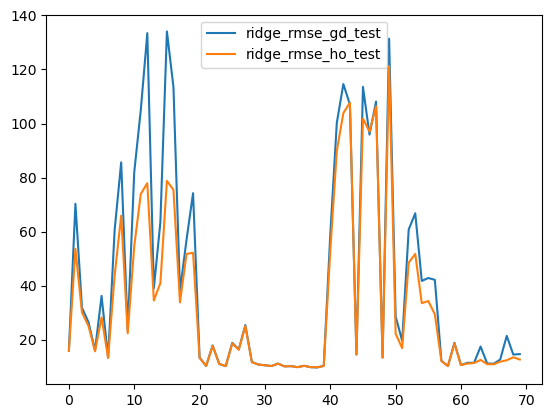

In [31]:
results_df[['ridge_rmse_gd_test', 'ridge_rmse_ho_test']].plot()

<Axes: >

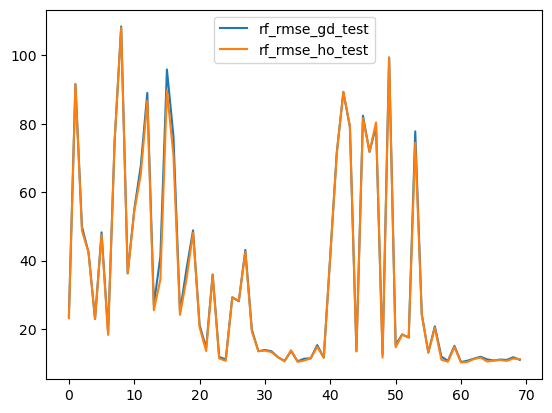

In [32]:
results_df[['rf_rmse_gd_test', 'rf_rmse_ho_test']].plot()

<Axes: >

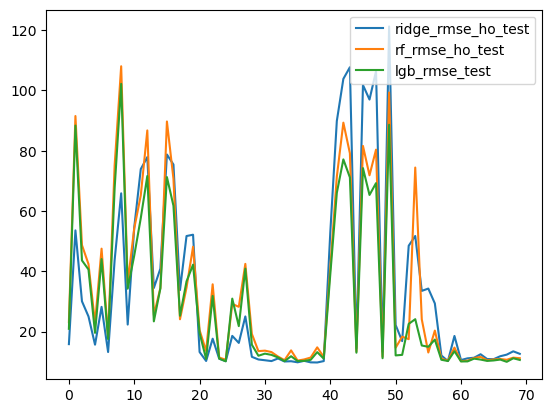

In [33]:
results_df[['ridge_rmse_ho_test', 'rf_rmse_ho_test', 'lgb_rmse_test']].plot()

In [34]:
prediction_df

,Date,store,product,number_sold,month,year,dayofweek,ridge_gd,ridge_ho,rf_gd,rf_ho,lgb
0,2019-01-01,0,0,845,1,2019,1,851.694938,852.313229,845.656291,844.658973,846.366451
1,2019-01-02,0,0,851,1,2019,2,851.110103,851.717331,843.565491,842.986846,845.571568
2,2019-01-03,0,0,840,1,2019,3,851.065652,851.671117,842.848001,843.149698,845.921806
3,2019-01-04,0,0,842,1,2019,4,850.999631,851.606111,844.303298,843.997841,845.921806
4,2019-01-05,0,0,845,1,2019,5,850.610923,851.207321,842.982941,842.116427,845.459287
...,...,...,...,...,...,...,...,...,...,...,...,...
25545,2019-12-27,6,9,901,12,2019,4,923.685595,918.878262,914.063295,907.930776,910.757917
25546,2019-12-28,6,9,926,12,2019,5,931.150584,925.725748,916.017989,915.255937,919.591180
25547,2019-12-29,6,9,913,12,2019,6,928.477863,923.272624,918.728314,916.525259,916.450283
25548,2019-12-30,6,9,899,12,2019,0,918.257822,913.895862,904.971956,904.392094,906.148432


In [37]:
for i in prediction_df.columns[-5:]:
    print(i)
    print('RMSE: ', mean_squared_error(prediction_df['number_sold'], prediction_df[i], squared=False))
    print()

ridge_gd
RMSE:  55.10128661396115

ridge_ho
RMSE:  45.060792533629645

rf_gd
RMSE:  44.666798943656154

rf_ho
RMSE:  43.88874350684407

lgb
RMSE:  38.78252935406796

